# Programmieren 2 Projekt Diabetes Health Indicators (Gruppe 7)

# 0. Vorbereitung

## 0.1 externe Bibliotheken installieren

In [2]:
# %pip install missingno

## 0.2 Bibliotheken, Funktionen und Klassen importieren

In [3]:
# Bibliotheken
import base64
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Selection
# from scipy import stats
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif, chi2, mutual_info_classif

# Feature Scaling 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Splitting Data
from sklearn.model_selection import StratifiedKFold

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn.multiclass import OneVsOneClassifier
# from sklearn.multiclass import OneVsRestClassifier

# Evaluation
from sklearn.metrics import f1_score, classification_report

## 0.3 Datensatz aus OneDrive einlesen
Der Datensatz wird aus OneDrive eingelesen. 

*Quelle: https://towardsdatascience.com/onedrive-as-data-storage-for-python-project-2ff8d2d3a0aa*

In [89]:
def create_onedrive_directdownload (onedrive_link):
    data_bytes64 = base64.b64encode(bytes(onedrive_link, 'utf-8'))
    data_bytes64_String = data_bytes64.decode('utf-8').replace('/','_').replace('+','-').rstrip("=")
    resultUrl = f"https://api.onedrive.com/v1.0/shares/u!{data_bytes64_String}/root/content"
    return resultUrl

df = pd.read_csv(create_onedrive_directdownload("https://1drv.ms/u/s!Ai0ffDmeM0ho1FNrZ1ho6d2NZqUV?e=MDLRDb"),sep=",", engine="python")
# df_large = pd.read_csv(create_onedrive_directdownload("https://1drv.ms/u/s!Ai0ffDmeM0ho1RKf3ExkvP3fLF0q?e=N106Gb"),sep=",", engine="python")

# 1. Business Understanding

## 1.1 Problemstellung

## 1.2 Ziel des Projekts

## 1.3 Kritische Faktoren

# 2. Data Understanding

In [5]:
# print(df_large.shape)
# print(df_large.columns)

## 2.1 Variablen und Skalenniveaus

Die Erklärung der Variablen des Datensatzes sind in der Beschreibung auf Kaggle bzw. in den Kommentaren zu finden. Zur Validierung der in Kaggle angegebenen Dokumentation kann der "Codebook Report" des Behavioral Risk Factor Surveillance System aus dem Jahr 2015 verwendet werden. Dieser beinhaltet eine Beschreibung des unbereinigten Datensatzes mit mehr als 300 Features. Da die Features beim Bereinigen zum Teil umbenannt wurden, ist es hilfreich, das Jupyter Notebook, das für die Bereinigung des großen Datensatzes erstellt wurde und auf Kaggle zu finden ist, hinzuzuziehen.

Link zum Datensatz (Kaggle): *https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset*

2015 Codebook Report (BRFSS): *https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf*

Link zum unbereinigten Datensatz: *https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system*

Link zum Jupyer Notebook zur Bereinigung: *https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook/notebook*

In [6]:
df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

### 2.1.1 Features

#### demographische Features:
**Sex**: nominalskaliert; 0 = weiblich, 1 = männlich

**Age**: ordinalskaliert; 1 = 18-24 Jahre alt, 2 = 25-29 Jahre alt, 3 = 30 bis 34 Jahre alt, 4 = 35 - 39 Jahre alt, 5 = 40 bis 44 Jahre alt, 6  = 45 - 49 Jahre alt, 7 = 50 - 54 Jahre alt, 8 = 55 - 59 Jahre alt, 9 = 60 - 64 Jahre alt, 10 = 65 - 69 Jahre alt, 11 = 70 - 74 Jahre alt, 12 = 75 - 79 Jahre alt, 13 = 80 oder älter

**Education**: ordinalskaliert; 1 = Kindergarten, 2 = Grundschule (Elementary School, Grade 1 through 8), 3 = Some High School  (Grade 9 through 11), 4 = High School Degree (Grade 12 or GED), 5 = College 1 year to 3 years (Some college or technical school), 6 = College 4 Years or more (College graduate)

**Income**: ordinalskaliert; 1 = < 10000 USD Einkommen, 2 = 10000 - 15000 USD , 3 = 15000 - 20000 USD, 4 = 20000 - 25000 USD, 5 = 25000 - 35000 USD, 6 = 35000 - 50000 USD, 7 = 50000 - 75000 USD, 8 = 75000+ USD

#### medizinische Features:
**HighBP**: nominalskaliert; 0 = kein hoher Blutdruck, 1 = hoher Blutdruck

**HighCol**: nominalskaliert; 0 = kein hoher Cholesterinspiegel, 1 = hoher Cholesterinspiegel

**CholCheck**: nominalskaliert; 0 = kein Cholesterincheck in den letzten 5 Jahren, 1 = Cholesterincheck in den letzten 5 Jahren

**HeartDieseaseorAttack**: nominalskaliert; 0 = keine Herzkrankheit oder Herzinfarkt, 1 = Herzkrankheit oder Herzinfarkt

**BMI**: intervallskaliert, [kg/m²]

**Stroke**: nominalskaliert; 0 = noch keinen Schlaganfall gehabt, 1 = Schlaganfall gehabt 

**AnyHealthCare**: nominalskaliert; 0 = keine Krankenversicherung, 1 = Krankenversicherung (bezogen auf USA)

**NoDocbcCost**: nominalskaliert; 0 = konnte in den letzten 12 Monaten immer zum Doktor gehen, 1 = in den letzten 12 Monaten 
Doktor gebraucht aber nicht leisten können (bezogen auf USA)

**GenHlth**: ordinalskaliert; genereller Gesundheitsstatus: 1 = exzellent, 2 = sehr gut, 3 = gut, 4 = in Ordnung, 5 = schlecht

**MenHlth**: intervallskaliert; Anzahl der Tage in den letzten 30 Tagen, an denen es einem mental nicht gut ging (Stress, Depression, emotionale Probleme) 

**PhysHlth**: intervallskaliert; Anzahl der Tage in den letzten 30 Tagen, an denen es einem körperlich nicht gut ging (körperliche Krankheit, Verletzung)

**DiffWalk**: nominalskaliert; 0 = keine Schwierigkeiten beim Laufen, 1 = Schwierigkeiten beim Laufen

#### "Lifestyle" Features:

**PhysActivity**: intervallskaliert; Anzahl der Tage in den letzten 30 Tagen, an denen man körperlich aktiv war

**Fruits**: nominalskaliert; 0 = isst weniger als eine Frucht pro Tag, 1 = isst eine oder mehr Früchte pro Tag

**Veggies**: nominalskaliert; 0 = isst weniger als ein Gemüse pro Tag, 1 = isst eine oder mehr Gemüse pro Tag

**HvyAlcoholConsump**: nominalskaliert; 0 = weniger als 14 Drinks (7 bei Frauen) pro Woche, 1 = mehr als 14 Drinks (7 bei Frauen) pro Woche

**Smoker**: nominalskaliert; 0 = nicht mehr als 100 Zigaretten im Leben geraucht, 1 = mehr als 100 Zigaretten im Leben geraucht

### 2.1.2 Target

**Diabetes_012**: nominalskaliert; 0 = gesund, 1 = prediabetes, 2 = diabetes

## 2.1.3 Variablen umbenennen

Die meisten Variablen des Datensatzes werden bereits durch ihre Namen ausreichend erklärt. Trotzdem gibt es ein paar Variablen, bei denen es zum vollständigen Verständnis der Bedeutung noch einer zusätzlichen Erläuterung bedarf. Diese werden direkt zu Beginn passend umbenannt, damit später im Code, nach der Umbennenung, keine Probleme auftreten.

In [96]:
df.rename(columns = {'Diabetes_012': 'Diabetes_Type', 'Sex': 'Sex_male'}, inplace = True)
df.columns

Index(['Diabetes_Type', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex_male', 'Age', 'Education',
       'Income'],
      dtype='object')

Es ist zu erkennen, dass die Zielvariable 'Diabetes_012' zu 'Diabetes_Type' umbenannt wurde. Darüber hinaus heißt das Feature, dass das Geschlecht eines Patienten beinhalten nun 'Sex_male', wobei der Patient männlich ist, wenn der Wert der Variable 1 (True) ist.  

## 2.2 Einblick in den  Datensatz

### 2.2.1 grundlegende Informationen über den Datensatz

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_Type         253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

### 2.2.1 Anzeige der ersten Zeilen

In [9]:
pd.set_option('display.max_columns', None)
df.head()

,Diabetes_Type,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex_male,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


### 2.2.2 Anzeige der letzten Zeilen

In [10]:
# df.tail()

### 2.2.3 Größe des Datensatzes

In [11]:
print(f'Der Datensatz hat {df.shape[0]} Zeilen und {df.shape[1]} Spalten.')

Der Datensatz hat 253680 Zeilen und 22 Spalten.


### 2.2.4 Anzahl der einzigartigen Werte pro Feature

In [12]:
df.nunique()

Diabetes_Type            3
HighBP                   2
HighChol                 2
CholCheck                2
BMI                     84
Smoker                   2
Stroke                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Sex_male                 2
Age                     13
Education                6
Income                   8
dtype: int64

## 2.3 Deskriptive Statistik im Datensatz

In [13]:
df.describe()

,Diabetes_Type,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex_male,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.296921,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,0.056197,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.698160,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,0.230302,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,2.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


## 2.4 Klassenverteilung im Datensatz bezüglich der Zielvariable

In [14]:
Diabetes_valuecount = df['Diabetes_Type'].value_counts()
Diabetes_valuecount

0.0    213703
2.0     35346
1.0      4631
Name: Diabetes_Type, dtype: int64

### 2.4.1 Visualisierung - Klassenverteilung im Datensatz

Zur Visualisierung der Klassenverteilung im Datensatz bezüglich der Targetvariable 'Diabetes_012' wird im Folgenden ein **Pieplot** mittels der pie()-Funktion aus der matplotlib-library erstellt.

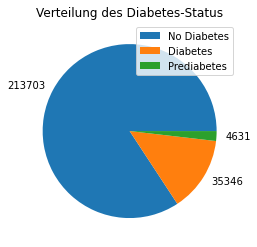

In [15]:
%matplotlib inline
labels = ['No Diabetes', 'Diabetes', 'Prediabetes']
plt.pie(Diabetes_valuecount, labels = Diabetes_valuecount)
plt.legend(labels)
plt.title('Verteilung des Diabetes-Status')
plt.show()

### 2.4.2 Ergebnis (absolute Werte) - Klassenverteilung im Datensatz 
Der Datensatz ist **unausgewogen**. Das bedeutet, dass eine Klasse des Datensatzes gegenüber den anderen deutlich über-/unterrepräsentiert ist.

213703 Personen im Datensatz haben kein Diabetes, 4631 Personen haben Pre-Diabetes, und 35346 Personen haben Diabetes.

### 2.4.3 Ergebnis (prozentualer Anteil) - Klassenverteilung im Datensatz

In [53]:
# df_diab_val_count = Diabetes_valuecount.to_frame(name='absolute Werte')
# df_diab_val_count['prozentual'] = df_diab_val_count['absolute Werte']/ df_diab_val_count.shape[0]
# df_diab_val_count

In [73]:
# Funktion zur Berechnung der prozentualen Klassenverteilung im Datensatz

def calc_prozentual_target(df):
    # Shape 
    df_diab0 = df.loc[df['Diabetes_Type'] == 0.0]
    df_diab1 = df.loc[df['Diabetes_Type'] == 1.0]
    df_diab2 = df.loc[df['Diabetes_Type'] == 2.0]

    df_diab0_count = df_diab0.shape[0]
    df_diab1_count = df_diab1.shape[0]
    df_diab2_count = df_diab2.shape[0]

    df_diab0_perc = round((df_diab0_count/df.shape[0])*100, 3)
    df_diab1_perc = round((df_diab1_count/df.shape[0])*100, 3)
    df_diab2_perc = round((df_diab2_count/df.shape[0])*100, 3)
    
    diabetes_perc_list = [df_diab0_perc, df_diab1_perc, df_diab2_perc]
    
    return diabetes_perc_list

In [55]:
diabetes_perc_df = calc_prozentual_target(df)

print(f'Der vollständige Datensatz enthält {diabetes_perc_df[0]} % gesunde Patienten, {diabetes_perc_df[1]} % Patienten mit Prediabetes und {diabetes_perc_df[2] }% Patienten mit \nDiabetes.')

Der vollständige Datensatz enthält 82.711 % gesunde Patienten, 2.015 % Patienten mit Prediabetes und 15.274% Patienten mit 
Diabetes.


## 2.5 Fehlende Werte

Zur Visualisierung möglicher fehlender Werte im Datensatz wird eine **Missing-Data-Matrix** mithilfe der missingno-Bibliothek erstellt. Diese besteht aus schwarzen Balken für die jeweiligen Variablen. Mögliche fehlende Werte wären durch weiße Striche in den Balken gekennzeichnet.

##### Visualisierung - Fehlende Werte

<AxesSubplot:>

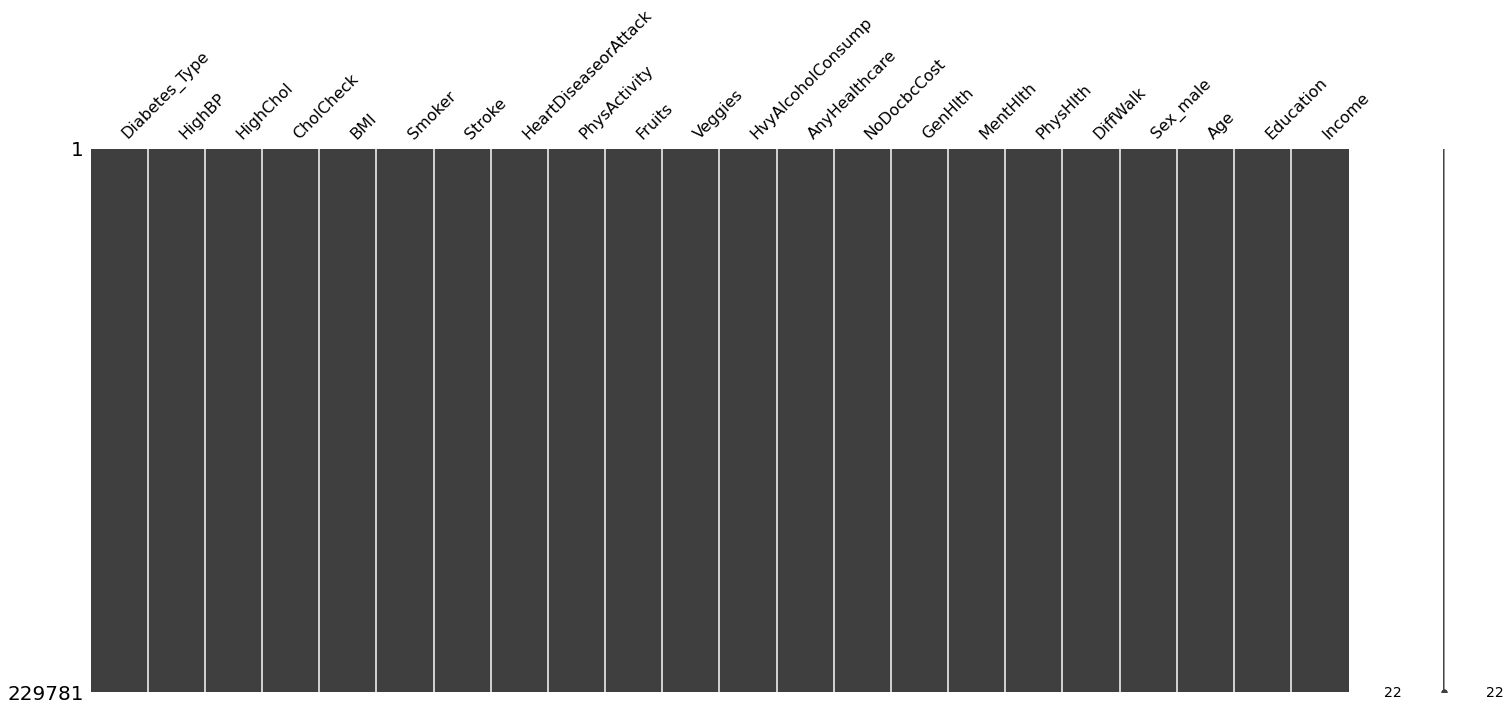

In [51]:
%matplotlib inline
msno.matrix(df)

##### Ergebnis - Fehlende Werte

In [52]:
print(f'Der Datensatz enthält {df.isnull().sum().sum()} fehlende Werte.')

Der Datensatz enthält 0 fehlende Werte.


Dies ist bereits in der Infotabelle unter Kapitel 2.2.1 zu erkennen, da bei keiner Variable die Anzahl von "non-null"-Werten von der Gesamtgröße des Datensatzes abweicht. In Kapitel 2.5.1 wird dies durch die graphische Veranschaulichung nochmals bestätigt. 

Da es sich beim Datensatz um einen bereits bereinigten Datensatz handelt, war dies bereits zu erwarten. Aufgrund der Vollständigkeit des Datensatzes ist eine weitere Behandlung möglicher fehlender Werte in Kap. 3 (Data Preparation) überflüssig.  

## 2.6 Explorative Analyse des Datensatzes

### 2.6.1 Visualisierung mit Boxplots
Um eine erste Idee vom Datensatz und möglichen **Ausreißern** bei den Features zu bekommen, wird jeweils ein **Boxplot** für jede nicht binäre Variable erstellt. Die Voraussetzung, um einen Boxplot berechnen zu können, ist eine Variable, die **mindestens Ordinalskalen-Niveau** hat. Zur Erstellung der Boxplots wird die boxplot()-Funktion aus der seaborn-library verwendet.

*https://www.statistikpsychologie.de/boxplot/#:~:text=Die%20Voraussetzung%2C%20um%20einen%20Boxplot,den%20Skalenniveaus%20findest%20du%20hier)*

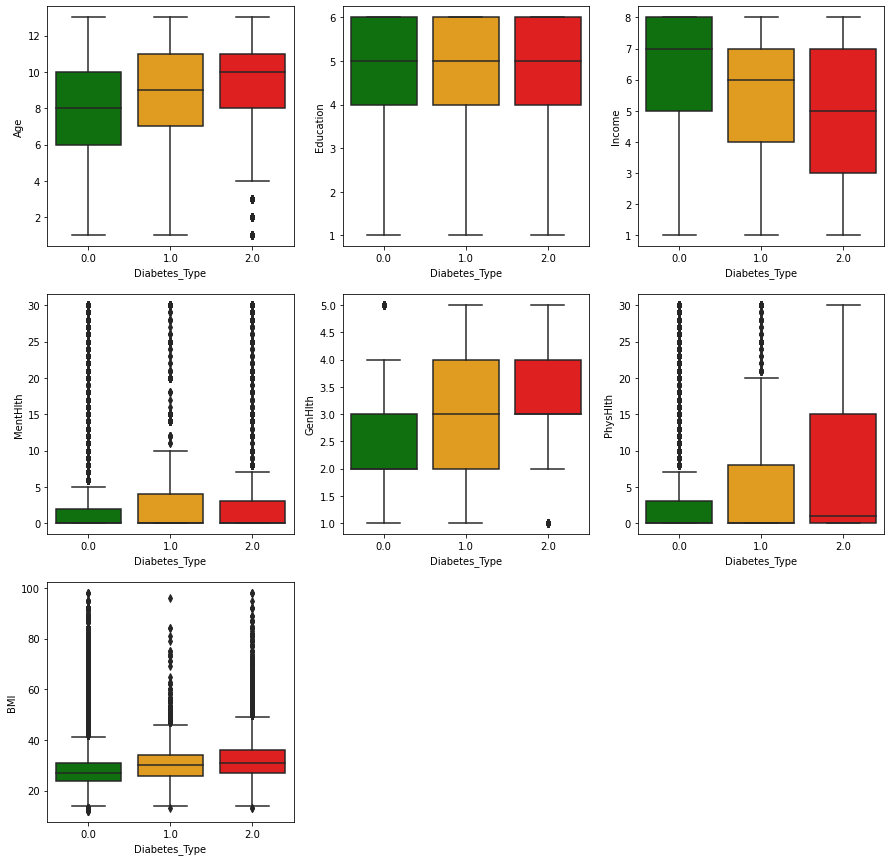

In [59]:
%matplotlib inline

features_boxplots = ['Age', 'Education', 'Income', 'MentHlth', 'GenHlth', 'PhysHlth', 'BMI']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

row_count = 0
col_count = 0

for feature in features_boxplots:
    sns.boxplot(ax=axes[row_count, col_count], data=df, x='Diabetes_Type', y=feature, palette=['Green', 'Orange', 'Red'])
    col_count += 1
    if col_count > 2:
        row_count += 1
        col_count = 0

fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])

##### Interpretation - Boxplots

In [20]:
# Erklärung, warum bei manchen Boxplots der Median nicht eingezeichnet ist

### 2.6.2 Visualisierung mit Säulendiagrammen
Zur Darstellung der Verteilung der **nominalskalierten** Variablen werden im Folgenden einige Säulendiagramme erstellt.

In [21]:
# Funktion zur Berechnung der bedingten Wahrscheinlichkeiten bestimmter Features unter der Bedinung des Diabetes-Status

def create_diabetes_feature_tab(feature):
    # DataFrame erstellen, der die Anzahl aller Zugehörigen eines Features unter der Bedinungen des Diabetes-Status enthält 
    diabetes_feature_count = df.groupby(['Diabetes_Type', feature]).size().reset_index(name = 'Count')
    # DataFrame erstellen, der die Anzahl aller Zugehörigen zum jeweiligen Diabetes-Typ enthält
    diabetes_count_total = diabetes_feature_count.groupby(['Diabetes_Type']).sum().Count
    # gerade erstellte DataFrames zusammenfügen
    diabetes_feature_count_tab = diabetes_feature_count.set_index('Diabetes_Type').join(diabetes_count_total,rsuffix='_Diabetes')
    # neue Spalte hinzufügen, die prozentualen Anteil von Personen einer Featureausprägung in Bezug auf jeweiligen Diabetestyp enthält
    diabetes_feature_count_tab['Percentage'] = diabetes_feature_count_tab['Count']/diabetes_feature_count_tab['Count_Diabetes']
    # Indizes des DataFrames zurücksetzen
    diabetes_feature_count_tab.reset_index(inplace = True)
    # Antworten leichter verständlich machen
    diabetes_feature_count_tab['Diabetes_Type'].replace({0.0: 'Healthy', 1.0: 'Prediabetes', 2.0: 'Diabetes'}, inplace=True)
    diabetes_feature_count_tab[feature].replace({0.0: 'No', 1.0: 'Yes'}, inplace=True)
    return diabetes_feature_count_tab

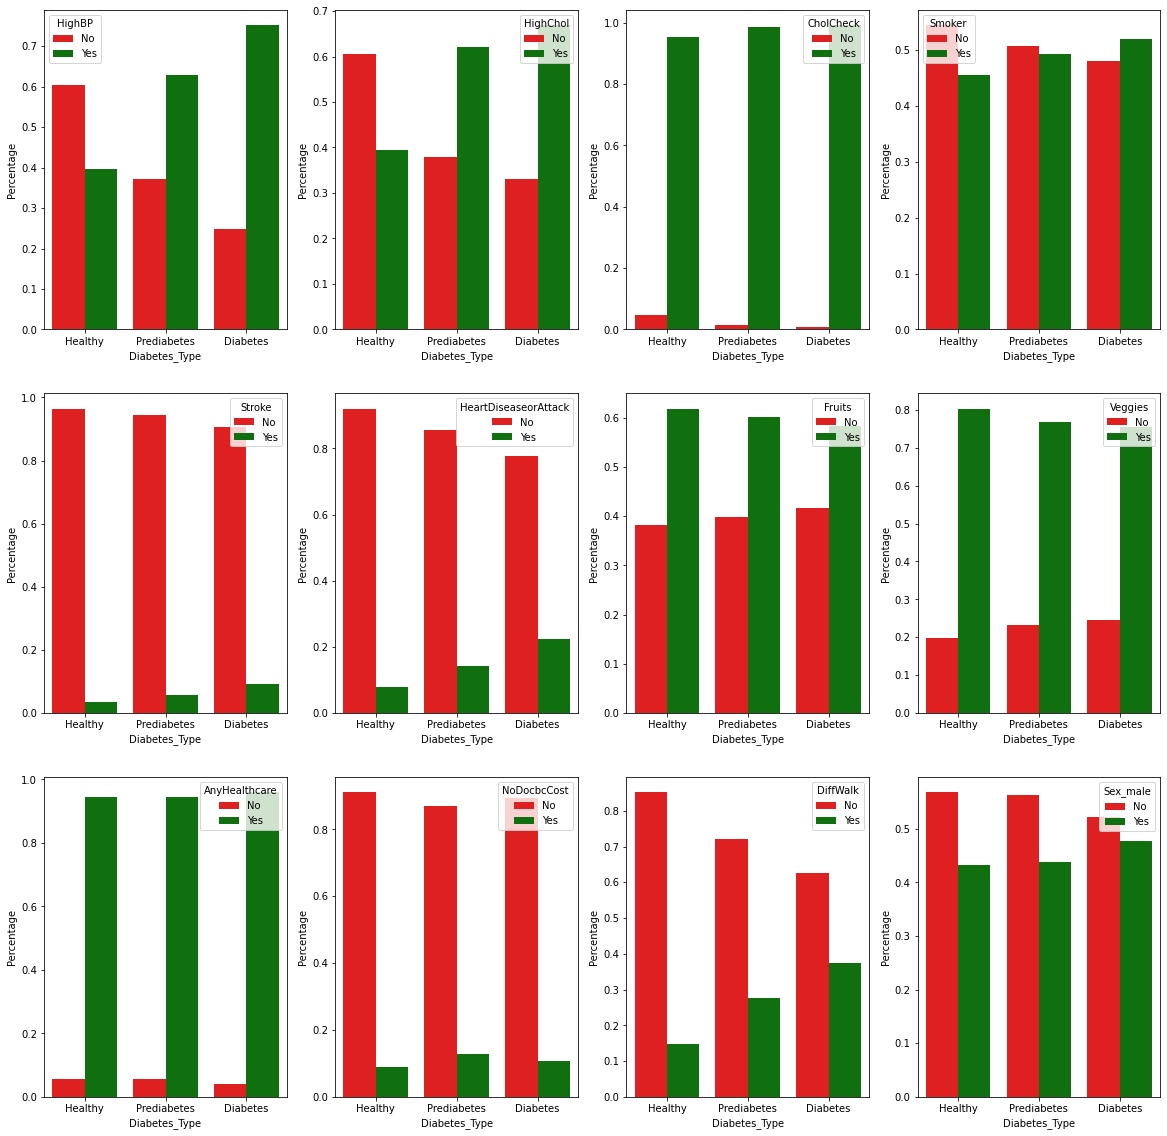

In [57]:
features_barplots = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke','HeartDiseaseorAttack', 'Fruits', 'Veggies', 
                     'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex_male']

fig, axes = plt.subplots(3, 4, figsize=(20,20))

row_count = 0
col_count = 0

for feature in features_barplots:
    diabetes_feature_count_tab = create_diabetes_feature_tab(feature)
    sns.barplot(x='Diabetes_Type', y='Percentage', hue=feature, data=diabetes_feature_count_tab, ax=axes[row_count, col_count], palette=['Red','Green'])
    # axes[row_count, col_count].title('Diabetes vs. ' + str(feature))
    col_count += 1
    if col_count > 3:
        row_count += 1
        col_count = 0

### 2.6.3 Visualisierung mit kde-Plots

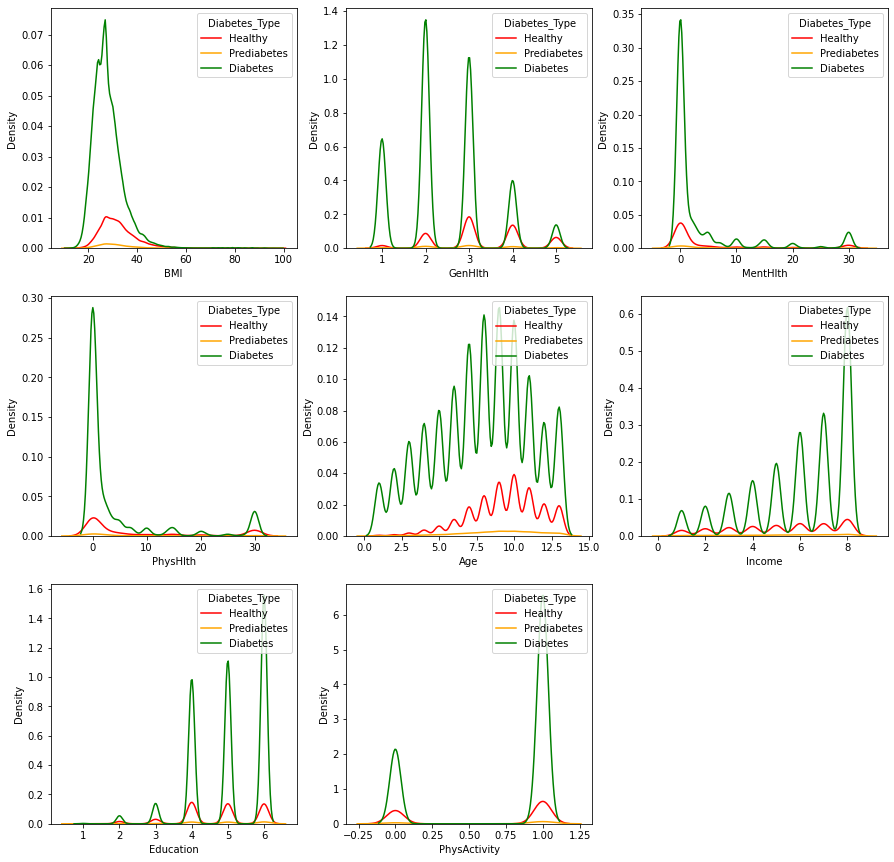

In [50]:
features_kdeplot = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Income', 'Education', 'PhysActivity']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

row_count = 0
col_count = 0

for feature in features_kdeplot:
    sns.kdeplot(ax=axes[row_count, col_count], data=df, x=feature, hue='Diabetes_Type', palette=['Green', 'Orange', 'Red'], legend=False)
    axes[row_count,col_count].legend(title='Diabetes_Type', loc='upper right', labels=['Healthy', 'Prediabetes', 'Diabetes'])
    col_count += 1
    if col_count > 2:
        row_count += 1
        col_count = 0
        
fig.delaxes(axes[2,2])
plt.show()

### Nähere Betrachtung einiger Features

In [85]:
# sns.barplot(x='HighChol', hue='CholCheck', data=df)
# distplot
# Plot Age vs. Gender

## 2.7 statistische Zusammenhänge zwischen den Variablen

### 2.7.1 Zusammenhang zwischen numerischen Inputs und kategorischem Output

#### 2.7.1.1 Kendall'scher Rangkorrelationskoeffizient

C:\Users\Max\anaconda3\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


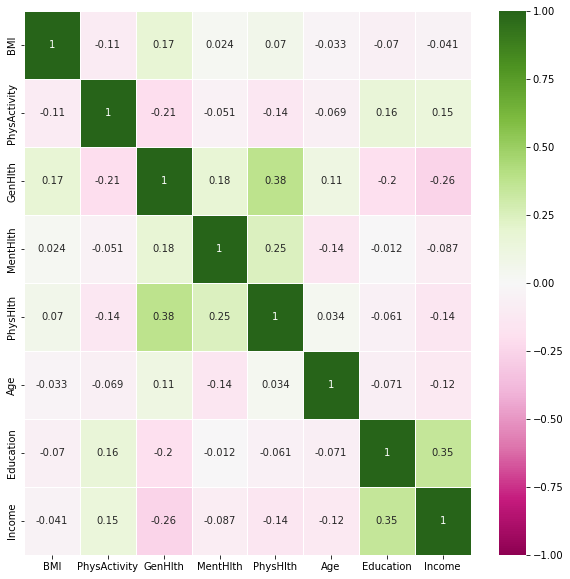

In [153]:
df_ordinal_or_more = df[['BMI', 'PhysActivity', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']]

fig = plt.figure(figsize=(10,10))
# sns.heatmap(df_ordinal_or_more.corr(method='kendall'), vmin=-1, vmax=1, cmap='RdYlGn', annot=True, linewidths=1)
sns.heatmap(df_ordinal_or_more.corr(method='kendall'), vmin=-1, vmax=1, cmap='PiYG', annot=True, linewidths=1)
plt.show()

#### 2.7.1.2 Analysis of Variance (ANOVA)

### 2.7.2 Zusammenhang zwischen kategorischen Inputs und kategorischem Output

In [82]:
# Erklärung welche Methoden hierfür verwendet werden dürfen

In [ ]:
# kategorisch = kategorial?

#### 2.7.2.1 Chi-Quadrat-Test

In [83]:
# Erklärung zum Chi-Quadrat-Test einfügen, kurz beschreiben warum Heatmap gewählt wurde
# Skalenniveaus überprüfen

In [26]:
categorical_features_list = ['Diabetes_Type', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                        'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk',
                       'Sex_male', 'Age', 'Education', 'Income']

chisqmatrix = pd.DataFrame(columns=categorical_features_list, index=categorical_features_list)

for i in categorical_features_list:
    for j in categorical_features_list:
        if i != j:
            chi2_val, p_val = chi2(np.array(df[i]).reshape(-1,1), np.array(df[j]).reshape(-1,1))
            chisqmatrix.loc[i, j] = p_val
        else:
            chisqmatrix.loc[i, j] = 0.0

##### Visualisierung - Chi-Quadrat-Test

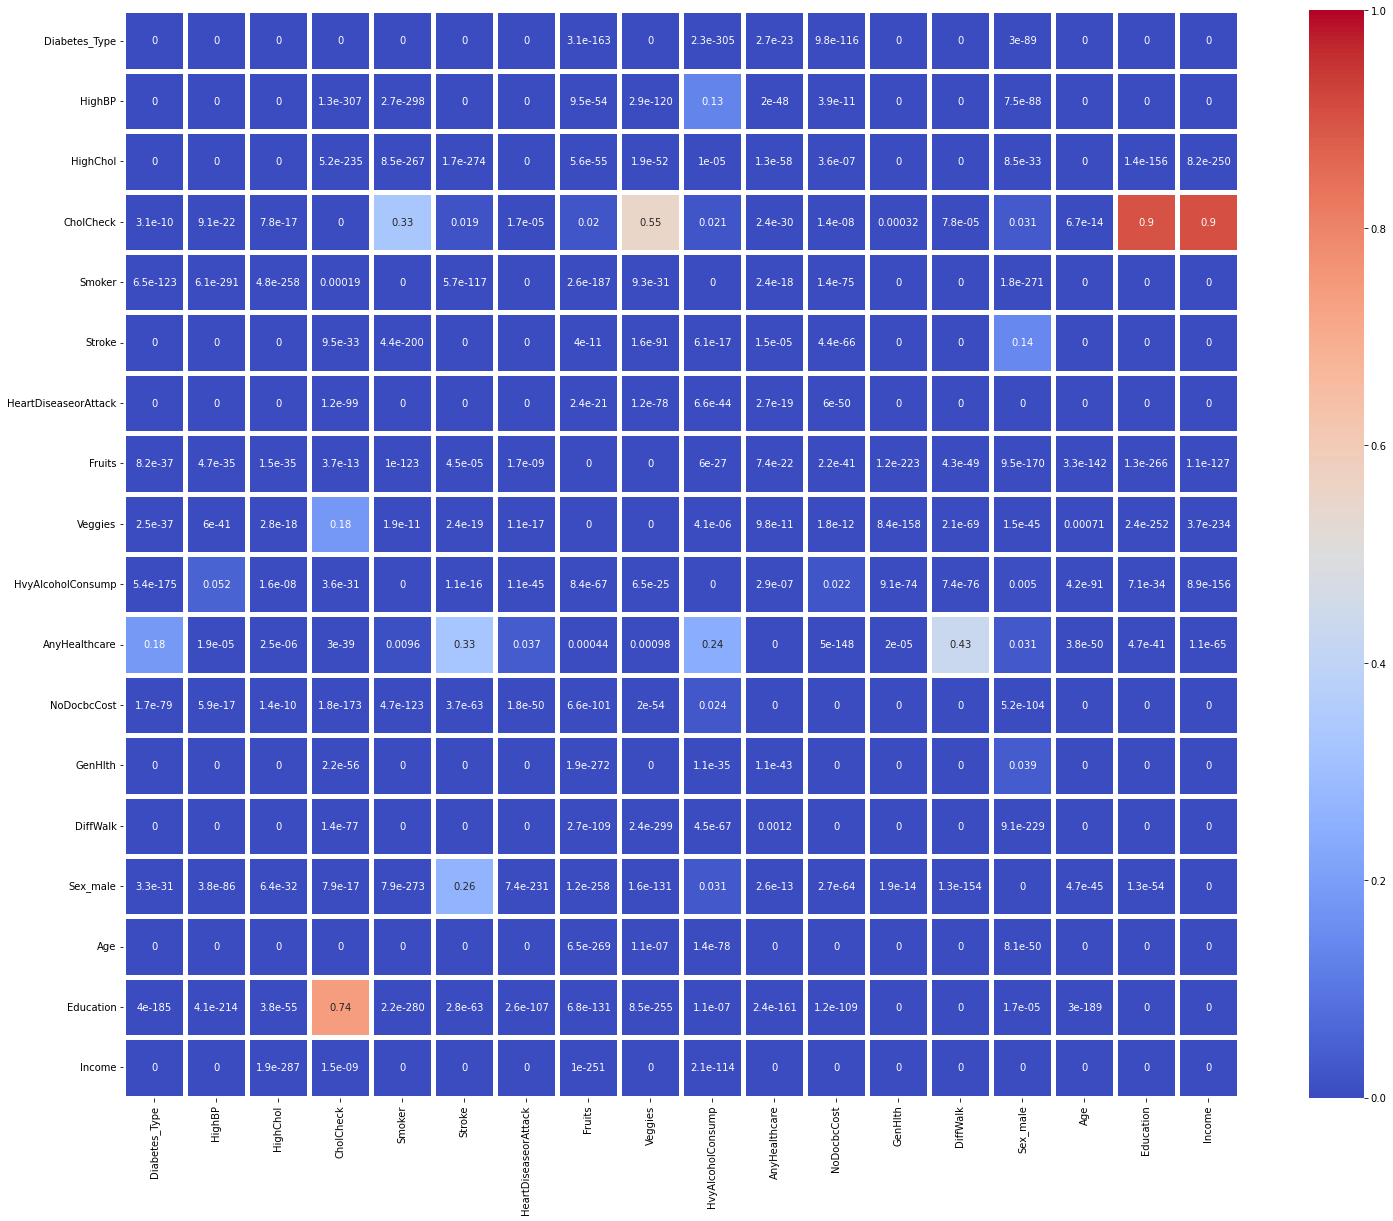

In [27]:
fig = plt.figure(figsize=(25,20))
sns.heatmap(chisqmatrix.astype(np.float64), annot=True, linewidths=5, vmin=0, vmax=1, cmap='coolwarm')
plt.show()

##### Interpretation - Chi-Quadrat-Test

In [152]:
# viele niedrige Werte wegen großer Stichprobenanzahl

##### Quellen zum Code (Chi-Quadrat-Test) 
*https://medium.com/analytics-vidhya/constructing-heat-map-for-chi-square-test-of-independence-6d78aa2b140f*
*https://www.analyticsvidhya.com/blog/2021/06/decoding-the-chi-square-test%E2%80%8A-%E2%80%8Ause-along-with-implementation-and-visualization/*

##### weitere Quellen (Chi-Quadrat-Test)
*https://datatab.de/tutorial/chi-quadrat*

# 3. Data Preparation

## 3.1 Data Cleaning

### 3.1.1 Duplikate entfernen

Im Bereich des Machine Learnings können **doppelte Feature Vektoren** aus verschiedenen Gründen **problematisch** werden. Fällt zum Beispiel eine Zeile nach dem Split in den Trainingsdatensatz und die andere, gleiche Zeile in den Testdatensatz, so hat das Modell diese Daten bereits gesehen. Hierdurch wird das anschließende Ergebnis verzerrt. (*https://deepchecks.com/what-is-data-cleaning/*) Hierbei könnten doppelte Zeilen im Datensatz zu **Overfitting** führen, wenn das Modell mehrmals mit den gleichen Daten trainiert wird. Um dies zu verhindern werden die Duplikate aus dem "Diabetes Health Indicators" Datensatz ausfindig gemacht und **entfernt**.

In [92]:
# Anzahl der Zeilen im unbereinigten Datensatz
print(f'Der unbereinigte Datensatz umfasst {df.shape[0]} Feature Vektoren.')

Der unbereinigte Datensatz umfasst 253680 Feature Vektoren.


In [99]:
duplicates = df[df.duplicated()]
print(f'Davon sind {len(duplicates)} Zeilen doppelt.')

Davon sind 0 Zeilen doppelt.


In [101]:
# Ausgabe der doppelten Zeilen
duplicates

,Diabetes_Type,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex_male,Age,Education,Income


In [94]:
# doppelte Zeilen werden entfernt
df.drop_duplicates(inplace = True)

In [102]:
# Anzahl der Zeilen im bereinigten Datensatz
print(f'Der bereinigte Datensatz beinhaltet noch die Daten von {df.shape[0]} Patienten.')

Der bereinigte Datensatz beinhaltet noch die Daten von 229781 Patienten.


In [97]:
df_dup_removed_diab_perc_list = calc_prozentual_target(df)

print(f'Der bereinigte Datensatz enthält {diabetes_perc_df[0]} % gesunde Patienten, {diabetes_perc_df[1]} % Patienten mit Prediabetes und {diabetes_perc_df[2] }% Patienten mit \nDiabetes.')

Der bereinigte Datensatz enthält 82.711 % gesunde Patienten, 2.015 % Patienten mit Prediabetes und 15.274% Patienten mit 
Diabetes.


##### Zusammenfassung - Doppelte Zeilen entfernen

Obwohl die Unbalanciertheit des Datensatzes durch das Entfernen der doppelten Zeilen etwas vergrößert wird, sprechen unter anderem die oben genanneten Gründe dafür, sie zur weiteren Bearbeitung aus dem Datensatz zu entfernen. 

### 3.1.2 Unplausible Werte

Aus dem unteren Boxplot in Kap. 2.5.1 und der Informationstabelle, die in Kap. 2.3 mithilfe von df.describe() erstellt wurde, lässt sich ein Maximalwert des BMI von 98kg/m² erkennen. Da man laut der deutschen Adipositas Gesellschaft bereits ab einem BMI über 40kg/m² unter Adipositas Grad III fällt, sind Werte ab einem BMI über 60kg/m² als kritisch einzustufen. (*https://adipositas-gesellschaft.de/bmi/*)

In [35]:
crit_value_bmi = 60
df_crit_bmi = df.loc[df['BMI'] > crit_value_bmi]
print(f'Der Datensatz beinhaltet {df_crit_bmi.shape[0]} Patienten, deren BMI über einem Wert von 60 kg/m² liegt.')

Der Datensatz beinhaltet 805 Patienten, deren BMI über einem Wert von 60 kg/m² liegt.


Da unser Datensatz relativ viele Feature Vektoren enthält, ist es nicht zwingend notwendig die unklaren BMI-Werte zu ersetzen. Allerdings soll durch ein mögliches Entfernen der entsprechenden Zeilen, die Unbalanciertheit des Datensatzes nicht vergrößert werden. Daher wird im Folgenden kurz die Verteilung der Patienten mit kritischem BMI-Wert bezüglich der Klassen des Targets dargestellt. 

In [36]:
df_crit_bmi['Diabetes_Type'].value_counts()

0.0    617
2.0    171
1.0     17
Name: Diabetes_Type, dtype: int64

In [81]:
# df_crit_bmi_removed_diab = df.drop(df.loc[df['BMI'] > crit_value_bmi])

# crit_bmi_removed_perc = calc_prozentual_target(df_crit_bmi_removed_diab)

# print(f'Der Datensatz ohne Patienten mit kritischem BMI-Wert beinhaltet {crit_bmi_removed_diab_perc[0]} % gesunde Patienten, {crit_bmi_removed_diab_perc[1]} % Patienten mit Prediabetes \nund {crit_bmi_removed_diab_perc[2]} % Patienten mit Diabetes.')

In [103]:
# evtl. Sensitivitätsanalyse erwähnen

## 3.2 Vorbereitung des Modellings

In [108]:
x_values = df.drop(['Diabetes_Type'],axis='columns')
y_value = df['Diabetes_Type']

### 3.2.1 Umgang mit kategorischen Daten

Da ein Machine Learning Algorithmus immer besser mit numerischen Werten arbeiten kann, als mit kategorischen Variablen. Aus diesem Grund müssen kategorische Daten häufig speziell für das Modelling vorbereitet werden, indem die kategorischen Werte in numerische Werte umgewandelt werden. Dies gilt sowohl für die Feature-, als auch für die Targetvariablen. (*https://analyticsindiamag.com/when-to-use-one-hot-encoding-in-deep-learning/#:~:text=One%20hot%20encoding%20can%20be,classification%20accuracy%20of%20a%20model.*) 

##### Quellen (Umgang mit kategorischen Daten)
*https://analyticsindiamag.com/when-to-use-one-hot-encoding-in-deep-learning/#:~:text=One%20hot%20encoding%20can%20be,classification%20accuracy%20of%20a%20model.*

*https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/*

*Sarkar, Bali, Sharma (2018): Practical Machine Learning with Python, S.204. Apress.*

### 3.2.2 Oversampling/ Undersampling

### 3.2.3 Feature Scaling

#### 3.2.3.1 Einführung in das Thema Feature Scaling

Wenn ein Modell mit unskalierten Daten trainiert wird, bei dem einige Features einen (deutlich) größeren Wertebereich haben, als andere, kann es beim Training des Modells dazu führen, dass diese Features einen größeren Einfluss auf den Ausgang des Modells haben. Obwohl ein paar Machine-Learning-Algorithmen, wie z.B. baumbasierte Methoden, auch ohne Feature Scaling auskommen, ist es üblich, diese vor dem Modelling zu skalieren. Dies gilt besonders, wenn man viele verschiedene Machine Learning Algorithmen testen und vergleichen will. (*Sarkar, Bali, Sharma (2018): Practical Machine Learning with Python, S.239. Apress.*)

Im Folgenden wird eine Funktion scale_data() implementiert, die einen DataFrame und eine Scaling-Methode entgegen nimmt, und den skalierten Datensatz zurückgibt. Diese wird im Modelling an geeigneter Stelle eingesetzt, um die **Daten zu Skalieren**. 

In [105]:
# es gibt verschiedene Methoden zum Skalieren der Features

In [104]:
def scale_data(df, scaler_method):
    scaler = scaler_method
    scaled_data = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(scaled_data, columns = df.columns)
    return df_scaled

#### 3.2.3.2 Vorbereitung - Feature Scaling

Genauso wie es wichtig ist das Modell mit unbekannten Testdaten zu testen, ist es auch wichtig, das Scaling innerhalb des Splits durchzuführen. *(Computing cross-validated metrics, 3.1.1 https://scikit-learn.org/stable/modules/cross_validation.html)* Anderenfalls könnte das Skalieren des gesamten Datensatzes dazu führen, dass Informationen aus dem Datensatz noch vor dem Test in das Modell geraten und das anschließende Ergebnis verzerren.

Im Folgenden wird innerhalb eines ersten Stratified KFold-Splits analysiert, ob verschiedene statistische Werte beim Skalieren des Modells in den verschiedenen Folds voneinander abweichen. Falls das nicht der Fall ist, kann das Scaling trotzdem auf den gesamten Datensatz angewendet werden. Darüber hinaus kann es hilfreich sein, um einen Eindruck über die Güte des gewählten Splits zu erhalten.

In [143]:
def data_scaling_cv(x_values, y_value, scaler):
    print(str(scaler))
    split_counter = 1
    skf = StratifiedKFold(n_splits=10)
    for train_index, test_index in skf.split(x_values, y_value):
        X_train, X_test = x_values.iloc[train_index], x_values.iloc[test_index]
        y_train, y_test = y_value.iloc[train_index], y_value.iloc[test_index]
        scaler = StandardScaler()
        scaled_train = scaler.fit_transform(X_train)
        scaled_test = scaler.transform(X_test)
        print(f'Values in Split {split_counter}: ')
        print(f'Traingsdatensatz: Minimum: {np.amin(scaled_train)}, Maximum: {np.amax(scaled_train)}, Mittelwert: {np.mean(scaled_train)}')
        print(f'Testdatensastz: Minimum: {np.amin(scaled_test)}, Maximum: {np.amax(scaled_test)}, Mittelwert: {np.mean(scaled_test)}')
        print()
        split_counter += 1 

In [144]:
scalers = [StandardScaler(), MinMaxScaler()]

for scaler in scalers:
    data_scaling_cv(x_values, y_value, scaler)

StandardScaler()
Values in Split 1: 
Traingsdatensatz: Minimum: -4.856955001912867, Maximum: 10.127000826546968, Mittelwert: -3.4031376006334293e-18
Testdatensastz: Minimum: -4.856955001912867, Maximum: 9.249746253326467, Mittelwert: -0.007755986173009365

Values in Split 2: 
Traingsdatensatz: Minimum: -4.819161511715352, Maximum: 10.105204755571531, Mittelwert: -4.115158799584062e-17
Testdatensastz: Minimum: -4.819161511715352, Maximum: 9.813288305969492, Mittelwert: 0.012297824032221166

Values in Split 3: 
Traingsdatensatz: Minimum: -4.8977831068770925, Maximum: 10.164063691433581, Mittelwert: -6.806242289388399e-19
Testdatensastz: Minimum: -4.8977831068770925, Maximum: 10.164063691433581, Mittelwert: -0.004017099037558871

Values in Split 4: 
Traingsdatensatz: Minimum: -4.850957763352184, Maximum: 10.927183805810776, Mittelwert: 4.3036393552902025e-17
Testdatensastz: Minimum: -4.850957763352184, Maximum: 10.927183805810776, Mittelwert: 0.015440834581432833

Values in Split 5: 
Trai

#### 3.2.3.3 Interpretation (Vorbereitung - Feature Scaling)

Es ist zu erkennen, dass weder die Minimal-, noch die Maximalwerte der skalierten Daten (sowohl mit dem StandardScaler(), als auch mit dem MinMaxScaler()) bei einem StratifiedKFold-Split mit 10 Folds deutlich voneinander abweichen. Hierdurch ist es möglich die Daten bereits vor dem Modelling mithilfe des ganzen Datensatzes durchzuführen, ohne dass es zu Verzerrungen des Modells kommt. Ein Grund hierfür könnte beispielsweise der relativ große Umfang unseres Datensatzes sein.

#### 3.2.3.4 Feature Scaling - Standartisieren mit dem StandardScaler

In [146]:
# Erklärung StandardScaler

In [148]:
df_scaled_ss = scale_data(df, StandardScaler())
df_scaled_ss

,Diabetes_Type,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex_male,Age,Education,Income
0,-0.449376,1.095675,1.124132,0.205356,1.667220,1.071208,-0.216455,-0.339257,-1.658403,-1.258473,0.508092,-0.254232,0.238745,-0.319852,2.253111,1.879074,1.141300,2.095383,-0.885023,0.295241,-0.987588,-1.381324
1,-0.449376,-0.912679,-0.889575,-4.869594,-0.543101,1.071208,-0.216455,-0.339257,0.602990,-1.258473,-1.968149,-0.254232,-4.188578,3.126450,0.374618,-0.454434,-0.516791,-0.477240,-0.885023,-0.351213,1.026729,-2.337131
2,-0.449376,1.095675,1.124132,0.205356,-0.101037,-0.933526,-0.216455,-0.339257,-1.658403,0.794614,-1.968149,-0.254232,0.238745,3.126450,2.253111,3.434746,2.799391,2.095383,-0.885023,0.295241,-0.987588,1.008193
3,-0.449376,1.095675,-0.889575,0.205356,-0.248391,-0.933526,-0.216455,-0.339257,0.602990,0.794614,0.508092,-0.254232,0.238745,-0.319852,-0.564629,-0.454434,-0.516791,-0.477240,-0.885023,0.941695,-1.994746,0.052387
4,-0.449376,1.095675,1.124132,0.205356,-0.690456,-0.933526,-0.216455,-0.339257,0.602990,0.794614,0.508092,-0.254232,0.238745,-0.319852,-0.564629,-0.065516,-0.516791,-0.477240,-0.885023,0.941695,0.019571,-0.903420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229776,-0.449376,1.095675,1.124132,0.205356,2.403993,-0.933526,-0.216455,-0.339257,-1.658403,0.794614,0.508092,-0.254232,0.238745,-0.319852,0.374618,-0.454434,0.035906,-0.477240,1.129914,-0.997666,1.026729,0.530290
229777,2.310686,1.095675,1.124132,0.205356,-1.574584,-0.933526,-0.216455,-0.339257,-1.658403,-1.258473,-1.968149,-0.254232,0.238745,-0.319852,1.313865,-0.454434,-0.516791,2.095383,-0.885023,0.941695,-3.001905,-0.903420
229778,-0.449376,-0.912679,-0.889575,0.205356,-0.101037,-0.933526,-0.216455,-0.339257,0.602990,0.794614,-1.968149,-0.254232,0.238745,-0.319852,-1.503875,-0.454434,-0.516791,-0.477240,-0.885023,-1.967347,0.019571,-1.859227
229779,-0.449376,1.095675,-0.889575,0.205356,-0.837810,-0.933526,-0.216455,-0.339257,-1.658403,0.794614,0.508092,-0.254232,0.238745,-0.319852,0.374618,-0.454434,-0.516791,-0.477240,1.129914,-0.351213,0.019571,-2.337131


#### 3.2.3.5 Feature Scaling - Normalisieren mit dem MinMaxScaler

In [149]:
# Erklärung MinMaxScaler

In [151]:
df_scaled_minmax = scale_data(df, MinMaxScaler())
df_scaled_minmax

,Diabetes_Type,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex_male,Age,Education,Income
0,0.0,1.0,1.0,1.0,0.325581,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.00,0.6,0.500000,1.0,0.0,0.666667,0.6,0.285714
1,0.0,0.0,0.0,0.0,0.151163,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.50,0.0,0.000000,0.0,0.0,0.500000,1.0,0.000000
2,0.0,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.00,1.0,1.000000,1.0,0.0,0.666667,0.6,1.000000
3,0.0,1.0,0.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.25,0.0,0.000000,0.0,0.0,0.833333,0.4,0.714286
4,0.0,1.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.25,0.1,0.000000,0.0,0.0,0.833333,0.8,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229776,0.0,1.0,1.0,1.0,0.383721,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.50,0.0,0.166667,0.0,1.0,0.333333,1.0,0.857143
229777,1.0,1.0,1.0,1.0,0.069767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.75,0.0,0.000000,1.0,0.0,0.833333,0.2,0.428571
229778,0.0,0.0,0.0,1.0,0.186047,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.083333,0.8,0.142857
229779,0.0,1.0,0.0,1.0,0.127907,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.50,0.0,0.000000,0.0,1.0,0.500000,0.8,0.000000


### 3.3.4 Feature Selection

Ein weiterer wichtiger Schritt, der bereits zu Beginn des Modellings eine Rolle spielen kann ist die Feature Selection. Hierbei versucht man die Features ausfindig zu machen, die den größten Einfluss auf die vorhergesagte Klasse der Targetvariable haben. Dies ist nötig, da eine große Anzahl von Features dazu führen kann, dass das Modell komplexer und schwerer zu interpretieren wird. (*Sarkar, Bali, Sharma (2018): Practical Machine Learning with Python, S.242. Apress.*) Feature Selection wird im Allgemeinen angewendet, um Overfitting zu vermeiden, die Accuracy zu erhöhen, und die Trainingsdauer zu minimieren (*https://machinelearningmastery.com/feature-selection-machine-learning-python/*) Zur Berechung der Feature Importance stehen einem verschiedene Methoden zur Verfügung. Im Allgemeinen werden zur tatsächlichen Auswahl geeigneter Features mehrere dieser Möglichkeiten durchgeführt und anschließend das Gesamtergebnis interpretiert. Ähnlich wie beim Scaling der Features bietet es sich an, die Feature Selection vorerst im Rahmen eines Splits durchzuführen.

In [40]:
numerical_feature = df[['BMI', 'MentHlth', 'PhysHlth']]
categorical_features = df.drop(['BMI', 'MentHlth', 'PhysHlth', 'Diabetes_Type'], axis = 'columns')

num_feat_ss = scale_data(numerical_feature, StandardScaler())

# cat_feat_ss = scale_data(categorical_features, StandardScaler())
cat_feat_mm = scale_data(categorical_features, MinMaxScaler())

In [41]:
# Funktion die SelectKBest-Funtion aus sklearn nutzt um die Wichtigkeit von n Features auszugeben

def univariate_selection_skbest(features, classifier, num_of_feats):
    fs = SelectKBest(score_func = classifier, k = num_of_feats)
    fit = fs.fit(features, df['Diabetes_Type'])
    selected_features_bool = list(fit.get_support())
    for feature, selected_bool in zip(features, selected_features_bool):
        print(str(feature) + ': ' + str(selected_bool))

In [42]:
def get_features(df):
    return df.drop('Diabetes_Type', axis = 'columns')

In [43]:
x_values = get_features(df)

x_values_mm = get_features(df_minmax)

x_values_ss = get_features(df_ss)

#### ANOVA

In [44]:
univariate_selection_skbest(num_feat_ss, f_classif, 1)

BMI: True
MentHlth: False
PhysHlth: False


In [45]:
univariate_selection_skbest(cat_feat_mm, chi2, 5)

HighBP: True
HighChol: True
CholCheck: False
Smoker: False
Stroke: False
HeartDiseaseorAttack: True
PhysActivity: False
Fruits: False
Veggies: False
HvyAlcoholConsump: False
AnyHealthcare: False
NoDocbcCost: False
GenHlth: True
DiffWalk: True
Sex_male: False
Age: False
Education: False
Income: False


In [46]:
univariate_selection_skbest(cat_feat_mm, mutual_info_classif, 5)

HighBP: True
HighChol: True
CholCheck: True
Smoker: False
Stroke: False
HeartDiseaseorAttack: False
PhysActivity: False
Fruits: False
Veggies: False
HvyAlcoholConsump: False
AnyHealthcare: True
NoDocbcCost: False
GenHlth: True
DiffWalk: False
Sex_male: False
Age: False
Education: False
Income: False


### Recursive Feature Elimination

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial')
rfe = RFE(model, n_features_to_select=5)
fit = rfe.fit(x_values_ss, df['Diabetes_Type'])

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

#### Darstellung der Ergebnisse

In [ ]:
sel_features_rfe = list(fit.support_)
features = list(x_values.columns)
i = 0

for i in range(len(features)):
    print(str(features[i] + ': ' + str(sel_features_rfe[i])))
    i += 1

### Recursive Feature Elimination with Cross Validation

In [ ]:
def rec_feat_el_cv(estimator, x_values):
    estimator = estimator
    min_features_to_select = 1
    rfecv = RFECV(estimator=estimator, cv=StratifiedKFold(5), min_features_to_select=min_features_to_select)
    rfecv.fit(x_values_mm,df['Diabetes_Type'])
    print(str(estimator))
    print('Optimal number of features:', rfecv.n_features_)

In [ ]:
models = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier()]

for model in models:
    rec_feat_el_cv(estimator=model, x_values = x_values_ss)

### Feature Importance 

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(n_estimators=10)
model.fit(x_values_mm,y_values)

sel_features_etc = list(model.feature_importances_)

for i in range(len(features)):
    print(str(features[i] + ': ' + str(sel_features_etc[i])))
    i += 1

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=list(df_features))
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 important features in data")
plt.show()

In [ ]:
Wenn bei allen Splits gleiche Feature Selection und Scaling --> Split gut gewählt; kann auf ganzen Datensatz gemacht werden

# 4. Modelling

## 4.1 Vorläufige Modellauswahl

# verschiedene Modelle mit Parametern initialisieren

In [ ]:
model_params = {
    'logistic_regression': {
        'model': LogisticRegression(multiclass = 'multinomial'),
        'params': {
            'penalty' = ['l2', None] 
            'solver' = ['newton-cg', 'sag', 'saga', 'lbfgs']
        }
    'random_forrest': RandomForrest()
    }
}

## Hyperparameter-Tuning

In [ ]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cvStratifiedKFoldFoldtifiedKFold(5))
    clf.fit(x_values_ss,df['Diabetes_Type'])
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

# 5. Evaluation

### Classification Report

In [ ]:
target_names = ['Healthy', 'Prediabetes', 'Diabetes']

print(classification_report(y_test_tts, clf_dtc.predict(x_test_tts), target_names = target_names))

### f1 Score

In [ ]:
# SVC
# print(f1_score(y_test_tts, clf_svm.predict(x_test_tts), average = None, labels = [0.0,1.0,2.0]))

# Decision Tree Classifier
# print(f1_score(y_test_tts, clf_dtc.predict(x_test_tts), average = None, labels = [0.0,1.0,2.0]))

# Random Forrest Classifier
# print(f1_score(y_test_tts, clf_rfc.predict(x_test_tts), average = None, labels = [0.0,1.0,2.0]))
# after Feature Selection
# print(f1_score(y_test_tts_sel, clf_rfc_sel.predict(x_test_tts_sel), average = None, labels = [0.0,1.0,2.0]))

# Quellen

##### Quellen (doppelte Zeilen entfernen)
*https://deepchecks.com/what-is-data-cleaning/*

##### Quellen (Feature Scaling)
*Sarkar, Bali, Sharma (2018): Practical Machine Learning with Python, S.239. Apress.*

*https://scikit-learn.org/stable/modules/cross_validation.html*